# Knowledge Graph Grounding for LLMs in SAP Ecosystem

The *Knowledge Graph Grounding for LLMs* initiative showcases the application of Retrieval-Augmented Generation (RAG) in integrating a Language Model (LLM) with data structured within a Knowledge Graph. This solution encapsulates the entire process, from constructing the Knowledge Graph (KG) from unstructured raw text to building a functional Chat application that can query and interact with this knowledge base.

As part of this R&D project, the following objectives are targeted:

1. **Evaluate LangChain Tools for Knowledge Graph Integration:** - Assess the LangChain ecosystem and its ability to handle interactions with Knowledge Graphs effectively. Specifically, this involves exploring LangChains tools to integrate various data sources, including enterprise-specific databases, into an LLM model.

2. **LLM-Assisted Knowledge Graph Construction:** - Investigate the feasibility of leveraging LLMs to automate the construction of Knowledge Graphs directly from raw text data. This includes exploring techniques for extracting entities, relationships, and attributes from structured and unstructured data sources, and how LLMs can assist in enhancing the accuracy and automation of this process.

3. **Evaluate Triplestore (RDF Store) in HANA Cloud:** - Conduct a hands-on evaluation of working with SAPs HANA Cloud triplestore, an RDF store, which is in Beta at the time of writing. The focus will be on assessing its developer experience, performance, and integration with SAPs broader ecosystem, especially its compatibility with other enterprise systems for managing semantic data.

### Potential Use Cases in SAP:

- **Enterprise Data Integration:** - By grounding LLMs with a Knowledge Graph, SAP systems can significantly enhance data integration and retrieval processes across multiple sources, improving the accuracy and speed of decision-making. This approach can be applied in areas such as finance, procurement, or customer relationship management (CRM).

- **Intelligent Chatbots for Enterprise Applications:** - The constructed Knowledge Graph can be used to power intelligent chatbots integrated into SAP S4HANA or SAP Fiori applications. These chatbots could assist employees with querying operational data, guiding them through business processes, or providing data-driven insights.

- **Automated Data Modeling:** - Using LLMs to assist in the automated creation of Knowledge Graphs from raw text could significantly reduce the time and effort required for data modeling, particularly in complex enterprise systems where textual data is abundant (e.g., contracts, specifications, manuals).

- **Enhanced Business Intelligence (BI):** - Grounding LLMs with structured data stored in a Knowledge Graph can facilitate advanced business intelligence applications. By querying the KG for insights, users can gain a deeper understanding of trends, performance, and operational bottlenecks in real-time.

- **Semantic Search in SAP Solutions:** - Knowledge Graph grounding could enable more advanced semantic search capabilities in SAP solutions, allowing users to query data using natural language and retrieve contextually relevant results rather than relying on traditional keyword-based searches.

**Data sample:**

- https://www.ebmud.com/application/files/3416/7771/2399/2312_-_Four_1500-HP_Main_Air_Compressor_Motors_FINAL.pdf
- https://docs.rs-online.com/d853/A700000006779737.pdf

but you can use your own data in pdf format.


This integration of LLMs with SAP Knowledge Graphs has the potential to transform how organizations manage, retrieve, and utilize enterprise data, particularly in environments that rely heavily on large volumes of unstructured or semi-structured data.

The results of your run may differ from the results in this notebook. Try, improve!


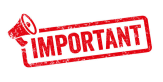

#### **Important Setup:**  .env File Required for AI CORE Access

Before running the application, ensure that the `.env` file is present in the same directory as the source code. This file contains the necessary credentials for accessing AI CORE.

The `.env` file should include the following lines with the appropriate values:

> AICORE_AUTH_URL="https://*xxxxxxx.authentication.eu10.hana.ondemand.com"  
> AICORE_CLIENT_ID= "xxxxxxxx"  
> AICORE_CLIENT_SECRET="xxxxx"  
> AICORE_BASE_URL="https://api.xxxxxxxx.hana.ondemand.com/v2"  
> AICORE_RESOURCE_GROUP="default"


**Make sure to replace the placeholders (`xxxxxxx`) with your actual AI CORE credentials.**


Environment Setup
This  block handles the setup of the environment.
It loads necessary credentials and configurations from a .env file.
Ensure your .env file includes AICORE access details before proceeding.

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
# Install necessary packages (langchain, rdflib, networkx, matplotlib etc.)
import os
import re
from gen_ai_hub.proxy.langchain.openai import ChatOpenAI
from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client


# Create a proxy client for the AI Hub
proxy_client = get_proxy_client('gen-ai-hub')
chat_llm = ChatOpenAI(proxy_model_name='gpt-4.1', proxy_client=proxy_client, temperature=0.0)

## Data Ingestion
Import raw data from the source. Build the Knowledge Graph using a Language Model (LLM)

In [3]:
from langchain.indexes.graph import GraphIndexCreator
from langchain_community.document_loaders import PyPDFLoader
from prompts import KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT

loader = PyPDFLoader("2312_-_Four_1500-HP_Main_Air_Compressor_Motors_FINAL.pdf")
docs = loader.load()
doc_content = 'This is a compressor specification: '
for doc in docs:
    doc_content = doc_content + ' ' + doc.page_content

index_creator = GraphIndexCreator(llm=chat_llm)

graph = index_creator.from_text(text=doc_content, prompt=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT)


## Extracted Triples

 **Objective:** Extract knowledge triples (subject-predicate-object) from the given text.

 **Method:** Use a pre-defined prompt and the OpenAI API to instruct the LLM to extract triples.

In [4]:
triples  = graph.get_triples()
print(triples)

[('Main Air Compressor Motor MAC 1-1', 'Equipment', 'is a'), ('Main Air Compressor Motor MAC 1-1', '1500-HP', 'has power rating'), ('Main Air Compressor Motor MAC 1-1', '4160V', 'operates at voltage'), ('Main Air Compressor Motor MAC 1-1', '60Hz', 'operates at frequency'), ('Main Air Compressor Motor MAC 1-1', '3600 RPM', 'has speed rating'), ('Main Air Compressor Motor MAC 1-1', '95% or higher at 100% load', 'has efficiency rating'), ('Main Air Compressor Motor MAC 1-1', 'power factor 0.936 or higher at full load', 'has load characteristic'), ('Main Air Compressor Motor MAC 1-1', 'locked rotor current 6.3 or less x FLA', 'has load characteristic'), ('Main Air Compressor Motor MAC 1-1', 'service factor 1.15 @ 105°C', 'has load characteristic'), ('Main Air Compressor Motor MAC 1-1', 'ambient temperature 40°C maximum', 'has temperature rating'), ('Main Air Compressor Motor MAC 1-1', 'Class F insulation with Class B temperature rise', 'has insulation class'), ('Main Air Compressor Motor M

In [5]:
triples[0][0]

'Main Air Compressor Motor MAC 1-1'

## KG - Simple Visualization
from langchain.indexes.graph - sometimes ready-made and quick visualizations don't look very nice

In [6]:
from IPython.display import SVG
graph.draw_graphviz(layout="dot", path="KF_simple.svg")
SVG('KF_simple.svg')

## KG Visualisation
Let's make a slightly more beautiful and self-explanatory visualization

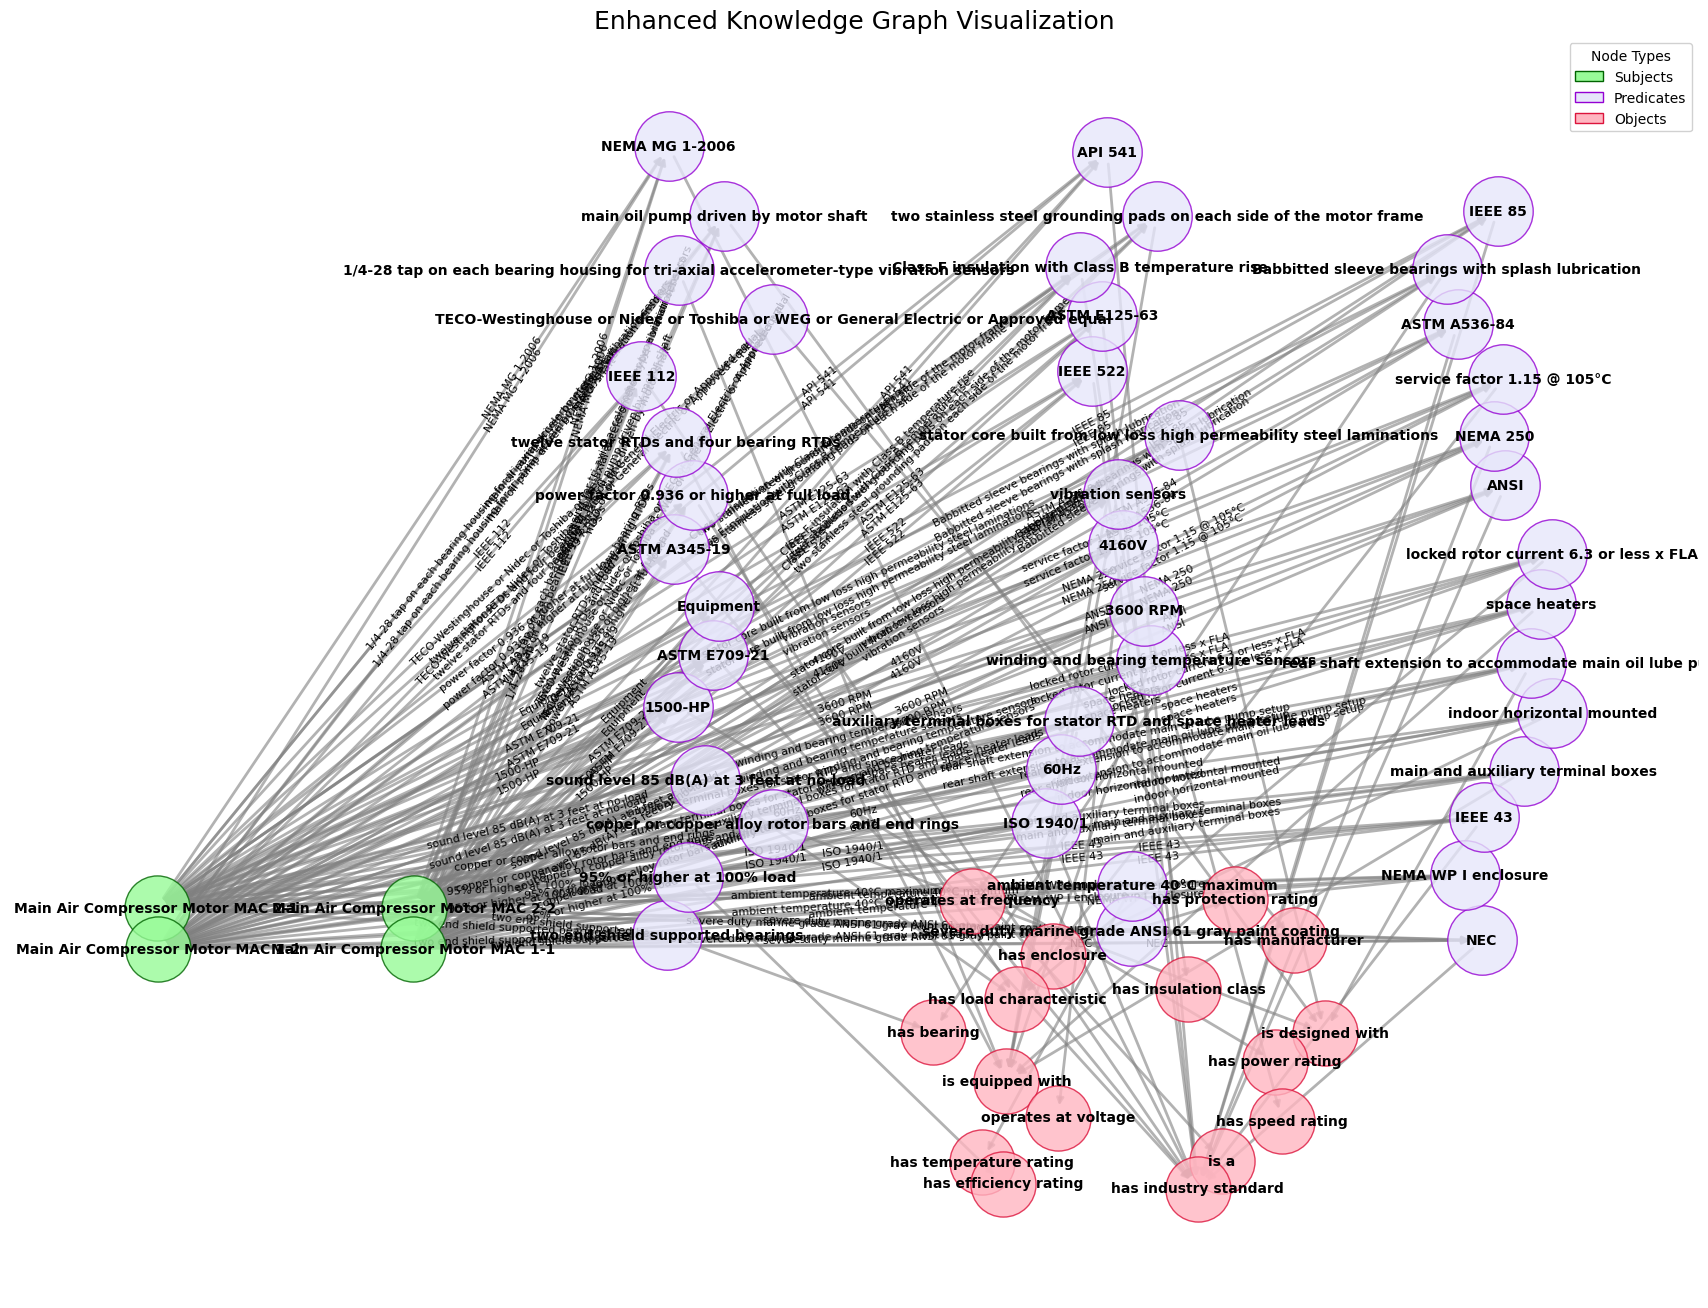

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_single_graph(graph):
    # Extract triples from the graph
    triples = graph.get_triples()
    G = nx.DiGraph()

    # Collect all types of nodes (subjects, predicates, and objects)
    subjects = {s for s, _, _ in triples}
    predicates = {p for _, p, _ in triples}
    objects = {o for _, _, o in triples}

    # Add nodes and edges based on the triples
    for s, p, o in triples:
        G.add_node(s)
        G.add_node(p)
        G.add_node(o)
        G.add_edge(s, p)
        G.add_edge(p, o)

    # Set the figure size for the visualization
    plt.figure(figsize=(18, 14))
    
    # Layout settings with increased distance between nodes
    pos = nx.spring_layout(G, k=2.0, iterations=200, seed=42)
    
    # Group nodes into categories
    node_groups = {
        "predicates": list(predicates),
        "subjects": list(subjects - predicates - objects),
        "objects": list(objects - subjects - predicates),
        "shared": list((subjects & objects) - predicates)
    }

    # Adjust positions as before...
    def adjust_positions(nodes, dx_pattern, dy_pattern):
        for i, node in enumerate(nodes):
            x, y = pos[node]
            pos[node] = (x + dx_pattern(i), y + dy_pattern(i))

    adjust_positions(node_groups["predicates"], 
                     lambda i: (i % 3) * 5.5, 
                     lambda i: (i // 3) * 5.5)
    adjust_positions(node_groups["subjects"],
                     lambda i: -4.0 - (i % 2) * 3.5,
                     lambda i: 3.0 - (i // 2) * 4.0)
    adjust_positions(node_groups["objects"],
                     lambda i: 4.0 + (i % 2) * 3.5,
                     lambda i: 3.0 - (i // 2) * 4.0)
    adjust_positions(node_groups["shared"],
                     lambda i: (i % 4) * 2.5 - 5.0,
                     lambda i: -4.0 - (i // 4) * 3.0)

    # Styling for different groups of nodes
    node_styles = {
        "predicates": {'color': '#E6E6FA', 'size': 2500, 'ec': 'darkviolet'},
        "subjects":   {'color': '#98FB98', 'size': 2200, 'ec': 'darkgreen'},
        "objects":    {'color': '#FFB6C1', 'size': 2200, 'ec': 'crimson'},
        "shared":     {'color': '#DDA0DD', 'size': 2400, 'ec': 'purple'}
    }

    # Draw nodes
    for group, style in node_styles.items():
        nx.draw_networkx_nodes(
            G, pos, nodelist=node_groups[group],
            node_size=style['size'],
            node_color=style['color'],
            edgecolors=style['ec'],
            alpha=0.8
        )

    # Labels and edges
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray')
    edge_labels = {(u, v): v if v in predicates else '' for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                 font_size=8, label_pos=0.7,
                                 bbox=dict(alpha=0))

    # Add a legend for the three main node types
    legend_handles = [
        mpatches.Patch(facecolor=node_styles["subjects"]['color'],
                       edgecolor=node_styles["subjects"]['ec'],
                       label='Subjects'),
        mpatches.Patch(facecolor=node_styles["predicates"]['color'],
                       edgecolor=node_styles["predicates"]['ec'],
                       label='Predicates'),
        mpatches.Patch(facecolor=node_styles["objects"]['color'],
                       edgecolor=node_styles["objects"]['ec'],
                       label='Objects'),
    ]
    plt.legend(handles=legend_handles,
               loc='upper right',
               title='Node Types',
               framealpha=0.9)

    # Final touches
    plt.title('Enhanced Knowledge Graph Visualization', fontsize=18)
    plt.axis('off')
    plt.tight_layout(pad=4.0)
    plt.savefig("KF_advanced.png", dpi=300)
    plt.show()

visualize_single_graph(graph)

Let's use the power of SPARQL in SAP HANA

#### **Important Setup:**  .env File Required for HANA Cloud Access

Before running the application, ensure that the `.env` file is present in the same directory as the source code. This file contains the necessary credentials for accessing HANA Cloud.

The `.env` file should include the following lines with the appropriate values:


> hana_address="xxxxx.hanacloud.ondemand.com"  
> hana_port= "443"  
> hana_user="xxxxx"  
> hana_password="xxxxxx"  
> hana_encrypt="default"


#### **Make sure to replace the placeholders (`xxxxxxx`) with your actual HANA Cloud credentials.**

In [8]:
from hdbcli import dbapi
import os
import json
import numpy as np

# Connection parameters
HANA_ADDRESS = os.getenv("hana_address")
HANA_PORT = os.getenv("hana_port")
HANA_USER = os.getenv("hana_user")
HANA_PASSWORD = os.getenv("hana_password")
GRAPH_NAME = "product_KG_pdf2"


# Functions for converting values to IRIs and literals
def to_iri(value: str, base: str = "http://example.com/") -> str:
    import re
    encoded_part = re.sub(
        r"[^a-zA-Z0-9\\-_\\.]", lambda m: f"%{ord(m.group(0)):02X}", value
    )
    return f"<{base}{encoded_part}>"

def to_literal(value: str) -> str:
    if value is None:
        return '""'
    escaped = (
        value.replace("\\", "\\\\")
        .replace('"', '\\"')
        .replace("\n", "\\n")
        .replace("\r", "\\r")
    )
    return f'"{escaped}"'


#### Prefixes in SAP HANA SPARQL

In this example, we used <http://example.com/> as the base URI, but you can choose any other. See more about prefixes below.

**What is an IRI?**  
An IRI is an extended URI that allows unique identification of resources (subjects, predicates, and objects) in distributed systems.

**Example of a full IRI:**  
<http://example.com/resource/CompressorMotor123>

**What is a prefix?**  
A prefix is a short alias for a long IRI — it makes writing and reading queries easier.

**Choosing your prefix:**  
Name it according to the task (e.g. `motor:`, `sensor:`, `device:`) and use it consistently.

**Why do you need prefixes:**  
- Reduce the amount of code  
- Improve readability  
- Make it easier to change the base URI  

**When to include public ontologies:**  
For standard terms and metadata (RDF, RDFS, schema.org, FOAF, Dublin Core) — to ensure semantic compatibility.

For standard terms and metadata (RDF, RDFS, schema.org, FOAF, Dublin Core) — to ensure semantic compatibility.


```sparql
PREFIX rdf:   <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:  <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <http://schema.org/>
PREFIX foaf:  <http://xmlns.com/foaf/0.1/>
PREFIX dc:    <http://purl.org/dc/elements/1.1/>
```

For more details on the PREFIX clause in SAP HANA SPARQL, see:

https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-sparql-reference-guide/prefix-clause?locale=en-US

In [9]:
# Connecting to SAP HANA
conn = dbapi.connect(
    address=HANA_ADDRESS, port=HANA_PORT, user=HANA_USER, password=HANA_PASSWORD
)
cursor = conn.cursor()

# Defining IRI for graph
graph_iri = to_iri(GRAPH_NAME, base="http://graph/")

# Bulk insertion of graph data
print("[INFO] Inserting data into the graph...")

# Prepare all triples in one SPARQL INSERT statement
triples_statements = []
for subj, pred, obj in triples:
    subj_iri = to_iri(subj, base="http://example.com/resource/")
    pred_iri = to_iri(pred, base="http://example.com/property/")
    obj_literal = to_literal(obj)
    triples_statements.append(f"    {subj_iri} {pred_iri} {obj_literal} .")

# Single bulk INSERT query
sparql_bulk_insert = f"""
INSERT DATA {{
  GRAPH {graph_iri} {{
{chr(10).join(triples_statements)}
  }}
}}
""".strip()

try:
    cursor.callproc("SPARQL_EXECUTE", [sparql_bulk_insert, "", None, None])
    print(f"[INFO] Bulk insert of {len(triples)} triples successful.")
except Exception as e:
    print(f"[ERROR] Bulk insert failed: {e}")
    print(f"[ERROR] Query:\n{sparql_bulk_insert}")

conn.commit()
cursor.close()


[INFO] Inserting data into the graph...
[INFO] Bulk insert of 176 triples successful.


In [10]:
from hdbcli import dbapi
import os

# Form and execute a SPARQL query
sparql_query = f"""
SELECT DISTINCT ?s ?p ?o
FROM {graph_iri}
WHERE {{
  ?s ?p ?o
}}
"""

print("[INFO] Executing SPARQL SELECT query...")
try:
    cursor.execute(f"SELECT * FROM SPARQL_TABLE('{sparql_query}')")
    results = cursor.fetchall()
    if results:
        print("[RESULT] Query results:")
        for row in results:
            # usualy row = (subject, predicate, object)
            print(row)
    else:
        print("[RESULT] No data found.")
except Exception as e:
    print(f"[ERROR] SPARQL SELECT query failed: {e}")

# Closing the connection
cursor.close()


[INFO] Executing SPARQL SELECT query...
[RESULT] Query results:
('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%201%2D1', 'http://example.com/property/vibration%20sensors', 'is equipped with')
('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%201%2D2', 'http://example.com/property/vibration%20sensors', 'is equipped with')
('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%201%2D1', 'http://example.com/property/space%20heaters', 'is equipped with')
('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%201%2D2', 'http://example.com/property/space%20heaters', 'is equipped with')
('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%201%2D1', 'http://example.com/property/winding%20and%20bearing%20temperature%20sensors', 'is equipped with')
('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%201%2D2', 'http://example.com/property/winding%20and%20bearing%20temperature%20sensors', 'is equipped w

### Let's put everything together into one set of functions to demonstrate how the KG query pipeline works

### Function Reference: SAP HANA Knowledge Graph Pipeline

Below you will find a summary of the main utility functions for building and querying a knowledge graph in SAP HANA using PDF extraction, LLMs, and SPARQL.

#### `connect_hana(hana_env, dbapi)`
Opens a connection to SAP HANA and returns the connection and cursor objects for use in subsequent queries and inserts.

#### `close_hana(conn, cursor)`
Closes the SAP HANA database cursor and connection, ensuring resources are released after each operation.

#### `extract_and_store_kg_from_pdf(pdf_filename, GRAPH_NAME, KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT, chat_llm, dbapi, to_iri, to_literal, hana_env)`
Reads a PDF file, extracts triples from its text using a large language model (LLM), and writes all triples to a specified knowledge graph in SAP HANA via a bulk SPARQL insert.

#### `get_unique_relations(GRAPH_NAME, dbapi, hana_env)`
Returns a list of all unique relation names (i.e., object values) present in the specified knowledge graph. Useful for understanding which kinds of facts are represented.

#### `get_triples_by_relations(GRAPH_NAME, relation_list, dbapi, hana_env)`
Retrieves all triples from the knowledge graph where the object (relation) matches any value in `relation_list`. This allows targeted extraction of facts relevant to specific business attributes.

#### `clear_kg_graph(GRAPH_NAME, dbapi, hana_env)`
Deletes all triples from the named graph in SAP HANA, effectively resetting the graph for a new extraction or test.

---

> These functions are designed to streamline the end-to-end workflow: loading data from documents, structuring it with LLM extraction, storing it in a graph database, and enabling efficient queries and graph maintenance.


In [11]:
# -- Connection helpers --
def connect_hana(hana_env, dbapi):
    """
    Opens a connection to SAP HANA and returns (conn, cursor).
    """
    conn = dbapi.connect(
        address=hana_env['hana_address'],
        port=hana_env['hana_port'],
        user=hana_env['hana_user'],
        password=hana_env['hana_password']
    )
    cursor = conn.cursor()
    return conn, cursor


def close_hana(conn, cursor):
    """
    Closes the SAP HANA cursor and connection.
    """
    cursor.close()
    conn.close()

# -- Core KG functions --
def extract_and_store_kg_from_pdf(pdf_filename, GRAPH_NAME, KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT, chat_llm, dbapi, to_iri, to_literal, hana_env):
    """
    Reads a PDF, extracts triples via LLM, and bulk writes them to KG in SAP HANA.
    Returns the list of triples.
    """
    from langchain_community.document_loaders import PyPDFLoader
    from langchain.indexes.graph import GraphIndexCreator

    loader = PyPDFLoader(pdf_filename)
    docs = loader.load()
    doc_content = 'This is a compressor specification: '
    for doc in docs:
        doc_content += ' ' + doc.page_content

    index_creator = GraphIndexCreator(llm=chat_llm)
    graph = index_creator.from_text(text=doc_content, prompt=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT)
    triples = graph.get_triples()

    conn, cursor = connect_hana(hana_env, dbapi)
    graph_iri = to_iri(GRAPH_NAME, base="http://graph/")

    print("[INFO] Inserting data into the graph...")
    triples_statements = []
    for subj, rel, obj in triples:
        subj_iri = to_iri(subj, base="http://example.com/resource/")
        rel_iri = to_iri(rel, base="http://example.com/property/")
        obj_literal = to_literal(obj)
        triples_statements.append(f"    {subj_iri} {rel_iri} {obj_literal} .")

    sparql_bulk_insert = f"""
    INSERT DATA {{
      GRAPH {graph_iri} {{
{chr(10).join(triples_statements)}
      }}
    }}
    """.strip()

    try:
        cursor.callproc("SPARQL_EXECUTE", [sparql_bulk_insert, "", None, None])
        print(f"[INFO] Bulk insert of {len(triples)} triples successful.")
    except Exception as e:
        print(f"[ERROR] Bulk insert failed: {e}")
        print(f"[ERROR] Query:\n{sparql_bulk_insert}")

    conn.commit()
    close_hana(conn, cursor)
    return triples

def get_unique_relations(GRAPH_NAME, dbapi, hana_env):
    """
    Returns all unique relation names (object values in the triple) from the specified KG.
    """
    conn, cursor = connect_hana(hana_env, dbapi)
    graph_iri = f"<http://graph/{GRAPH_NAME}>"
    unique_relations = set()
    sparql_query = f"""
    SELECT "o"
    FROM SPARQL_TABLE(
      'SELECT DISTINCT ?o
       FROM {graph_iri}
       WHERE {{ ?s ?p ?o }}'
    ) AS "result"
    """
    try:
        cursor.execute(sparql_query)
        results = cursor.fetchall()
        for row in results:
            if row and row[0]:
                unique_relations.add(str(row[0]))
    except Exception as e:
        print(f"[ERROR] Failed to retrieve relations: {e}")
    close_hana(conn, cursor)
    return list(unique_relations)

def get_triples_by_relations(GRAPH_NAME, relation_list, dbapi, hana_env):
    """
    Returns all triples in the graph with object matching any in relation_list (relation = object in this case).
    """
    conn, cursor = connect_hana(hana_env, dbapi)
    graph_iri = f"<http://graph/{GRAPH_NAME}>"
    # Build FILTER clause for objects
    obj_conditions = " || ".join([f'?o = "{rel}"' for rel in relation_list])
    sparql_query = f"""
    SELECT "s", "p", "o"
    FROM SPARQL_TABLE(
      'SELECT ?s ?p ?o
       FROM {graph_iri}
       WHERE {{
         ?s ?p ?o .
         FILTER({obj_conditions})
       }}'
    ) AS "result"
    """
    triples = []
    try:
        cursor.execute(sparql_query)
        results = cursor.fetchall()
        for row in results:
            triples.append((row[0], row[1], row[2]))
    except Exception as e:
        print(f"[ERROR] Failed to retrieve triples: {e}")
    close_hana(conn, cursor)
    return triples


def clear_kg_graph(GRAPH_NAME, dbapi, hana_env):
    """
    Deletes all triples from the specified named graph in SAP HANA.
    """
    conn, cursor = connect_hana(hana_env, dbapi)
    graph_iri = f"<http://graph/{GRAPH_NAME}>"
    sparql_delete = f"CLEAR GRAPH {graph_iri}"
    try:
        cursor.callproc("SPARQL_EXECUTE", [sparql_delete, "", None, None])
        print(f"[INFO] Graph {GRAPH_NAME} cleared successfully.")
    except Exception as e:
        print(f"[ERROR] Failed to clear graph: {e}")
        print(f"[ERROR] Query:\n{sparql_delete}")
    close_hana(conn, cursor)


# -- Usage example --
hana_env = {
    'hana_address': HANA_ADDRESS,
    'hana_port': HANA_PORT,
    'hana_user': HANA_USER,
    'hana_password': HANA_PASSWORD,
}


GRAPH_NAME = "KG_pdf_tmp_01"

# 0. Extract triples and store in KG
triples = extract_and_store_kg_from_pdf(
    pdf_filename="2312_-_Four_1500-HP_Main_Air_Compressor_Motors_FINAL.pdf",
    GRAPH_NAME=GRAPH_NAME,
    KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT,
    chat_llm=chat_llm,
    dbapi=dbapi,
    to_iri=to_iri,
    to_literal=to_literal,
    hana_env=hana_env
)


# Testing functions:

# 1. Get all unique relation names (object values) in the graph
relations = get_unique_relations(GRAPH_NAME, dbapi, hana_env)
print("Unique relations:", relations)

# 2. Get all triples for a list of relations (object values)
relation_list = [
    "has efficiency rating",
    "operates at voltage"
]
triples_filtered = get_triples_by_relations(GRAPH_NAME, relation_list, dbapi, hana_env)
for t in triples_filtered:
    print("Triple:", t)

# 3. Clear all triples in a named graph
clear_kg_graph(GRAPH_NAME, dbapi, hana_env)


[INFO] Inserting data into the graph...
[INFO] Bulk insert of 328 triples successful.
Unique relations: ['operates at frequency', 'has protection rating', 'has enclosure', 'has industry standard', 'has bearing', 'has load characteristic', 'has insulation class', 'is equipped with', 'has power rating', 'is designed with', 'operates at voltage', 'has speed rating', 'has temperature rating', 'is a', 'has efficiency rating', 'has manufacturer']
Triple: ('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%202%2D1', 'http://example.com/property/4160V', 'operates at voltage')
Triple: ('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%202%2D2', 'http://example.com/property/4160V', 'operates at voltage')
Triple: ('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%202%2D1', 'http://example.com/property/95%25%20or%20higher%20at%20100%25%20load', 'has efficiency rating')
Triple: ('http://example.com/resource/Main%20Air%20Compressor%20Motor%20MAC%202%

### `ask_llm_simple(prompt: str) -> str`
Sends a prompt string to a Large Language Model (LLM) and returns the generated response as a string.



In [12]:
def ask_llm_simple(prompt: str) -> str:
   try:
       llm = ChatOpenAI(proxy_model_name='gpt-4o', proxy_client=proxy_client)
       result = llm.invoke(prompt)
       return result.content
   except Exception as e:
       print(f"⚠️ LLM Call Error: {e} | Prompt (first 100 chars): {prompt[:100]!r}")
       raise

print(ask_llm_simple("1+1"))


1 + 1 equals 2.


### `filter_relations_by_business_question(relations, business_question, ask_llm_simple)`

Given a list of property (relation) names from the knowledge graph and a business question in plain English, this function uses a Large Language Model (LLM) to select only those relations that are relevant for answering the question.



In [13]:
import re
import ast

def filter_relations_by_business_question(relations, business_question, ask_llm_simple):
    """
    Filters a list of property names, returning only those that are relevant to the user's natural language business question.
    
    :param relations: List of all property/relation names from the knowledge graph.
    :param business_question: A natural language business question or task (e.g., 'Compare energy efficiency').
    :param ask_llm_simple: Function to call LLM with a prompt and get a response.
    :return: List of relations the LLM judges as relevant.
    """
    prompt = (
        "You are helping to analyze business data using a knowledge graph.\n"
        f"Here is a list of property names from the knowledge graph:\n{relations}\n"
        f"The user asks: \"{business_question}\"\n"
        "From the list above, select ONLY the properties that are directly relevant to answering or summarizing this user's question.\n"
        "Return a Python list with only the relevant property names, with no explanation."
    )
    response = ask_llm_simple(prompt).strip()
    import re, ast
    # Try to extract the first Python list from the response
    list_match = re.search(r'(\[[^\]]*\])', response)
    if not list_match:
        # Try assignment style: something = [...]
        assign_match = re.search(r'=\s*(\[[^\]]*\])', response)
        if assign_match:
            list_str = assign_match.group(1)
        else:
            print("[WARN] LLM response did not contain a Python list:", response)
            return []
    else:
        list_str = list_match.group(1)
    try:
        filtered = ast.literal_eval(list_str)
        if isinstance(filtered, list):
            return [x for x in filtered if x in relations]
    except Exception as e:
        print("[WARN] Could not parse list from LLM response:", list_str)
    return []

# Example usage:
relations = [
    "is a", "has efficiency rating", "has insulation class", "has power rating",
    "has load characteristic", "has speed rating", "operates at voltage",
    "operates at frequency", "has manufacturer", "has frame", "has enclosure"
]
business_question = "Summarize the energy efficiency of this motor"
relevant = filter_relations_by_business_question(relations, business_question, ask_llm_simple)
print("Relevant relations:", relevant)

Relevant relations: ['has efficiency rating', 'has insulation class']


## Graph RAG

### Scenario 1

In this example, a procurement expert receives a PDF document with the technical specifications for an industrial motor. Instead of searching manually through the document for important details, the engineer uses an automated system to extract a structured knowledge graph from the PDF. Next, the engineer asks a business question such as, “Summarize the energy efficiency of this motor.” The system automatically determines which characteristics in the knowledge graph are relevant for energy efficiency, retrieves those facts, and uses a language model (LLM) to generate a short, clear summary in response to the question. This way, the engineer quickly gets exactly the information needed, saving time and avoiding manual work.

In [14]:
business_question = "Summarize the energy efficiency of this motor."
pdf_filename = "A700000008070326.pdf"         # your PDF file with equipment spec
GRAPH_NAME = "KG_pdf_demo_01"

# 1. Extract triples from the PDF and store them in SAP HANA KG
triples = extract_and_store_kg_from_pdf(
    pdf_filename=pdf_filename,
    GRAPH_NAME=GRAPH_NAME,
    KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT,
    chat_llm=chat_llm,
    dbapi=dbapi,
    to_iri=to_iri,
    to_literal=to_literal,
    hana_env=hana_env
)

# 2. Get all property/relation names present in the new KG
relations = get_unique_relations(GRAPH_NAME, dbapi, hana_env)
print("All relations found in KG:", relations)

# 3. Use the LLM to filter only those relations that are relevant for the business question
relevant_relations = filter_relations_by_business_question(relations, business_question, ask_llm_simple)
print("Relevant relations for the question:", relevant_relations)

# 4. Retrieve only the triples that match the relevant relations
triples_for_summary = get_triples_by_relations(GRAPH_NAME, relevant_relations, dbapi, hana_env)
print("Triples selected for summary:", triples_for_summary)

# 5. Build a summary with the LLM using only the relevant triples
if triples_for_summary:
    # Create a prompt with the selected triples
    summary_prompt = (
        f"You are an equipment expert. Given the following technical facts:\n"
        f"{triples_for_summary}\n"
        f"Please provide a concise summary that answers this question: {business_question}\n"
    )
    summary = ask_llm_simple(summary_prompt)
    print("=" * 60)
    print("Summary:\n", summary)
    print("=" * 60)
else:
    print("No relevant facts found for this question in the current knowledge graph.")

# 6. (Optional) Clean up graph after demo
clear_kg_graph(GRAPH_NAME, dbapi, hana_env)


[INFO] Inserting data into the graph...
[INFO] Bulk insert of 59 triples successful.
All relations found in KG: ['operates at frequency', 'has protection rating', 'has load characteristic', 'has insulation class', 'is designed with', 'is equipped with', 'has power rating', 'operates at voltage', 'has speed rating', 'has temperature rating', 'is a', 'has efficiency rating', 'has industry standard']
Relevant relations for the question: ['has efficiency rating']
Triples selected for summary: [('http://example.com/resource/1AV3112B%20SIMOTICS%20GP%20%2D%20112%20M%20%2D%20IM%20B5%20%2D%204p', 'http://example.com/property/88.6%25%20at%20400V%20%394%2050Hz', 'has efficiency rating'), ('http://example.com/resource/1AV3112B%20SIMOTICS%20GP%20%2D%20112%20M%20%2D%20IM%20B5%20%2D%204p', 'http://example.com/property/90.0%25%20at%20460V%20%394%2060Hz', 'has efficiency rating'), ('http://example.com/resource/1AV3112B%20SIMOTICS%20GP%20%2D%20112%20M%20%2D%20IM%20B5%20%2D%204p', 'http://example.com/pro

In [15]:
print(summary)

The energy efficiency of the 1AV3112B SIMOTICS GP 112 M IM B5 4p motor varies depending on the voltage and frequency. At 400V and 50Hz, the motor has efficiency ratings of 88.6%, 89.2%, and other values. At 460V and 60Hz, efficiency ratings range from 87.7% to 90.0%. At 690V and 50Hz, efficiency ratings are 88.6% and 89.2%. These variations show how the motor's efficiency changes with different electrical conditions.


### Scenario 2

In this scenario, a procurement expert is reviewing two different industrial motors to decide if one can be used as a replacement for the other. The expert receives two PDF documents, each with the technical specifications for one of the motors. Instead of comparing details manually, the expert uses an automated system to extract a knowledge graph from each PDF. The expert then asks a specific business question, such as, “Can Motor B replace Motor A in our setup? Please focus on power rating and other key technical attributes.” The system identifies which properties in the knowledge graphs are important for this decision, retrieves the relevant facts from both motors, and uses a language model (LLM) to provide a clear, side-by-side comparison based on the business requirements. This helps the expert make an informed decision quickly and with confidence.

In [16]:
pdf_filename_A = "A700000008070326.pdf"  # Motor A
pdf_filename_B = "A700000006779737.pdf"  # Motor B
GRAPH_NAME_A = "KG_motor_A"
GRAPH_NAME_B = "KG_motor_B"
business_question = (
    "Can Motor B replace Motor A in our setup? "
    "Please focus on power rating and any other important technical attributes."
)

# 1. Extract triples and store in separate KGs
triples_A = extract_and_store_kg_from_pdf(
    pdf_filename=pdf_filename_A,
    GRAPH_NAME=GRAPH_NAME_A,
    KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT,
    chat_llm=chat_llm,
    dbapi=dbapi,
    to_iri=to_iri,
    to_literal=to_literal,
    hana_env=hana_env
)
triples_B = extract_and_store_kg_from_pdf(
    pdf_filename=pdf_filename_B,
    GRAPH_NAME=GRAPH_NAME_B,
    KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT,
    chat_llm=chat_llm,
    dbapi=dbapi,
    to_iri=to_iri,
    to_literal=to_literal,
    hana_env=hana_env
)

# 2. Get all relations from both KGs
relations_A = get_unique_relations(GRAPH_NAME_A, dbapi, hana_env)
relations_B = get_unique_relations(GRAPH_NAME_B, dbapi, hana_env)
all_relations = list(set(relations_A) | set(relations_B))
print("All relations in both KGs:", all_relations)

# 3. Use the LLM to filter only those relations relevant for the replacement question
relevant_relations = filter_relations_by_business_question(all_relations, business_question, ask_llm_simple)
print("Relevant relations for replacement decision:", relevant_relations)

# 4. Retrieve the relevant triples from each graph
triples_A_relevant = get_triples_by_relations(GRAPH_NAME_A, relevant_relations, dbapi, hana_env)
triples_B_relevant = get_triples_by_relations(GRAPH_NAME_B, relevant_relations, dbapi, hana_env)

print("Motor A relevant triples:", triples_A_relevant)
print("Motor B relevant triples:", triples_B_relevant)

# 5. Pass both sets of triples to the LLM for a side-by-side comparison
comparison_prompt = (
    f"You are a technical expert. Here are the relevant technical facts for Motor A:\n"
    f"{triples_A_relevant}\n"
    f"And here are the relevant facts for Motor B:\n"
    f"{triples_B_relevant}\n"
    f"Based on these, answer the following business question: {business_question}\n"
    f"Give a clear, practical comparison, and say whether Motor B can reasonably replace Motor A."
)
comparison = ask_llm_simple(comparison_prompt)
print("=" * 60)
print("Replacement comparison summary:\n", comparison)
print("=" * 60)

# 6. (Optional) Clean up graphs after demo
clear_kg_graph(GRAPH_NAME_A, dbapi, hana_env)
clear_kg_graph(GRAPH_NAME_B, dbapi, hana_env)


[INFO] Inserting data into the graph...
[INFO] Bulk insert of 53 triples successful.
[INFO] Inserting data into the graph...
[INFO] Bulk insert of 28 triples successful.
All relations in both KGs: ['operates at frequency', 'has load characteristic', 'has power rating', 'has speed rating', 'operates at voltage', 'has protection rating', 'has insulation class', 'is designed with', 'is equipped with', 'has temperature rating', 'is a', 'has efficiency rating', 'has industry standard']
Relevant relations for replacement decision: ['has power rating', 'has load characteristic', 'has speed rating', 'operates at voltage', 'has temperature rating', 'has efficiency rating']
Motor A relevant triples: [('http://example.com/resource/1AV3112B%20SIMOTICS%20GP%20%2D%20112%20M%20%2D%20IM%20B5%20%2D%204p', 'http://example.com/property/sound%20level%2070.0%20dB%28A%29%20at%2060Hz', 'has load characteristic'), ('http://example.com/resource/1AV3112B%20SIMOTICS%20GP%20%2D%20112%20M%20%2D%20IM%20B5%20%2D%204

In [17]:
print(comparison)

To determine whether Motor B can replace Motor A in your setup, we need to compare the key technical attributes, particularly focusing on power rating, efficiency, and other relevant features.

### Power Rating:
**Motor A:**
- Operates at several power ratings:
  - 4.00 kW at 690V Y 50Hz
  - 4.00 kW at 400V Δ 50Hz
  - 4.55 kW at 460V Δ 60Hz
  - 3.70 kW at 460V Δ 60Hz

**Motor B:**
- Operates at a single power rating:
  - 0.75 kW

### Efficiency Rating:
**Motor A:**
- Efficiency ratings at different loads:
  - 88.6% at 400V Δ 50Hz
  - 89.2% at 400V Δ 50Hz
  - 90.0% at 460V Δ 60Hz
  - 89.5% at 460V Δ 60Hz
  - 89.4% at 460V Δ 60Hz

**Motor B:**
- Efficiency ratings at different loads:
  - 80.7% at 100% load
  - 80.8% at 75% load
  - 78.5% at 50% load
  - IE3 efficiency class

### Operating Voltage:
**Motor A:**
- Operates at multiple voltages:
  - 460V Δ
  - 400V Δ
  - 690V Y

**Motor B:**
- Operates at:
  - 400V ± 5%

### Speed Rating:
**Motor A:**
- Different speed ratings:
  - 1460 RPM